In [1]:
import os
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
from math import log2

from tools.utils.settings import DefaultPath as defpath

import statistics
from collections import defaultdict

from tools.utils.utils import get_mongodb_collections, get_query_ids_from_query_file

In [2]:
test_dir = defpath.data_path.josie_tests + '/full'
results_dir = test_dir + '/results'

p = 10
algorithms = ['josie', 'lshforest']
modes = ['set', 'bag']

solvers = dict()

for algorithm in algorithms:
    for mode in modes:
        fname = f"{results_dir}/a{algorithm}_m{mode}_k{p}_extracted.csv"

        if not os.path.exists(fname):
            continue
        solvers[(algorithm, mode)] = pd.read_csv(fname).convert_dtypes()

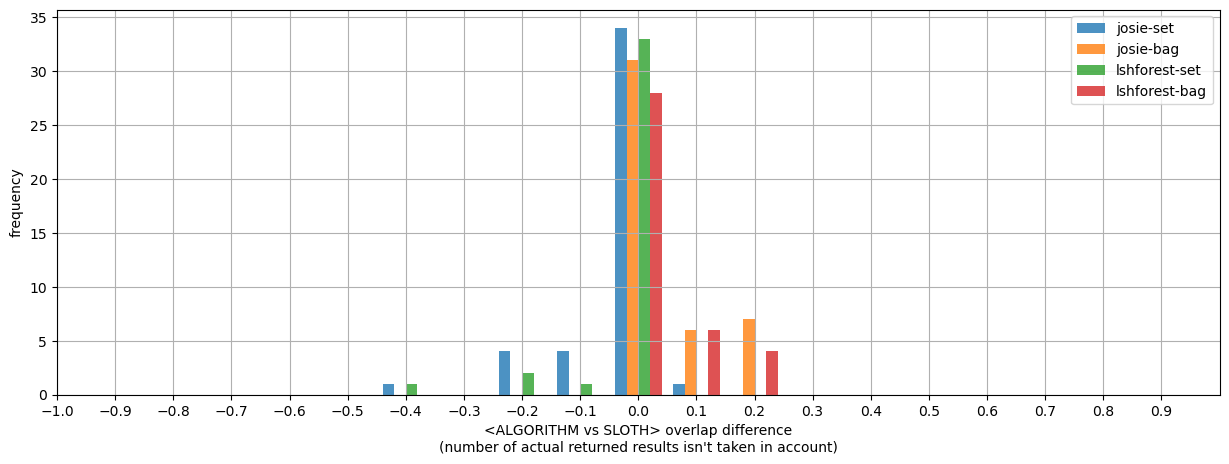

In [3]:
fig, ax = plt.subplots(1, 1, sharey='row', figsize=(15, 5))
xmin, xmax = -1, 1

ax.hist([res['difference_overlap_norm'] for _, res in solvers.items()], 
         bins=np.arange(xmin, xmax, 0.1), alpha=0.8, 
         label=[f'{solver[0]}-{solver[1]}' for solver, _ in solvers.items()],
         align='left')
ax.set_xlim(xmin, xmax)
ax.set_xticks(np.arange(xmin, xmax, 0.1))
ax.grid()
ax.set_xlabel('<ALGORITHM vs SLOTH> overlap difference\n(number of actual returned results isn\'t taken in account)')
ax.set_ylabel('frequency')


plt.legend()
plt.show()

### Creating Silver Standard

In [4]:
small = True
p = 10

test_name = 'full'

test_dir = defpath.data_path.josie_tests + '/' + test_name
results_dir = test_dir + '/results'
query_file = test_dir + '/query.json'

algorithms = ['josie', 'lshforest']
modes = ['set', 'bag']

sampled_ids = get_query_ids_from_query_file(query_file)

silver_standard = defaultdict(set)

for algorithm in algorithms:
    for mode in modes:
        fname = f"{results_dir}/a{algorithm}_m{mode}_k{p}_extracted.csv"

        if not os.path.exists(fname):
            continue
        
        results_ids = pd.read_csv(fname).convert_dtypes().groupby(by='query_id')[['result_id', 'sloth_overlap']]

        for query_id, ids_overlaps in results_ids:
            for i in ids_overlaps.values:
                _id, _overlap = i
                silver_standard[query_id].add((_id, _overlap))
        
for query_id in silver_standard.keys():
    silver_standard[query_id] = sorted(list(silver_standard[query_id]), key=lambda x: x[1], reverse=True)

In [5]:
mongoclient, collections = get_mongodb_collections(small)

In [6]:
############### ANALYSIS PRECISION-AT-K ##################
# For each query (aka silver standard), the algorithm ALG returned at least the K best
# results among all?

k_precision = 5

solvers = dict()

for algorithm in algorithms:
    for mode in modes:
        fname = f"{results_dir}/a{algorithm}_m{mode}_k{p}_extracted.csv"

        if not os.path.exists(fname):
            continue
        solvers[(algorithm, mode)] = pd.read_csv(fname).convert_dtypes()

precision_at_k_results = []

for query_id in silver_standard.keys():
    qss = [x[1] for x in silver_standard[query_id]]
    avg_overlap = round(statistics.mean(qss), 3)
    stdev_overlap = round(statistics.stdev(qss))

    for solver, result in solvers.items():
        ids = result[result['query_id'] == query_id]['result_id'].values.tolist()
        real_topk = [x[0] for x in silver_standard[query_id][:k_precision]]
        precision_at_k = set(real_topk).intersection(ids)
        
        precision_at_k_results.append([query_id, len(qss), avg_overlap, stdev_overlap, solver[0], solver[1], k_precision, len(precision_at_k)])

columns = [
    'query_id',
    'silver_std_size',
    'silver_std_ov_mean',
    'silver_std_ov_stdev',
    'algorithm',
    'mode',
    'k',
    'precision_at_k'
]

precision_at_k_results = pd.DataFrame(precision_at_k_results, columns=columns)
precision_at_k = precision_at_k_results.sort_values(by=['silver_std_size', 'query_id'], ascending=False)
precision_at_k

,query_id,silver_std_size,silver_std_ov_mean,silver_std_ov_stdev,algorithm,mode,k,precision_at_k
8,7312,28,13.143,12,josie,set,5,0
9,7312,28,13.143,12,josie,bag,5,4
10,7312,28,13.143,12,lshforest,set,5,0
11,7312,28,13.143,12,lshforest,bag,5,1
0,5161,27,1.296,0,josie,set,5,4
1,5161,27,1.296,0,josie,bag,5,5
2,5161,27,1.296,0,lshforest,set,5,1
3,5161,27,1.296,0,lshforest,bag,5,0
12,10568,24,5.375,2,josie,set,5,4
13,10568,24,5.375,2,josie,bag,5,4


### Normalized Discontinued Cumulative Gain (nDCG)

Search result lists vary in length depending on the query. Comparing a search engine's performance from one query to the next cannot be consistently achieved using DCG alone, so the cumulative gain at each position for a chosen value of $ p $ should be normalized across queries. This is done by sorting all relevant documents in the corpus by their relative relevance, producing the maximum possible DCG through position $p$, also called Ideal DCG (IDCG) through that position. For a query, the normalized discounted cumulative gain, or nDCG, is computed as: 

$ nDCG_{p} = {DCG_{p} \over IDCG_{p}} $

where $ IDCG_{p} $ is the ideal discounted cumulative gain,

$ IDCG_{p} = \sum_{i=1}^{|REL_{p}|} {2^{rel_{i}} - 1 \over log_{2}(i + 1)}$

where $ REL_{p} $ represents the list of relevant documents (ordered by their relevance) in the corpus up to position $p$

In [96]:
from sklearn.metrics import ndcg_score

def ndcg_at_p(true_relevance, scores, p):
    p = min(p, len(true_relevance), len(scores))
    if p <= 1: # because computing nDCG is meaningful only if there is more than one document 
        return 0, 1

    return ndcg_score(
        np.asarray([true_relevance[:p]]), 
        np.asarray([scores[:p]]), 
        k=p
    ), p

In [99]:
def get_nDCG_p(silver_standard:defaultdict[int:list[tuple[int,int]]], solvers:defaultdict[tuple[str,str]:pd.DataFrame], *p):
    """ p values are assumed positive """
    ndcg_res = []
    for query_id in silver_standard:
        true_relevances = [x[0] for x in silver_standard[query_id]]

        for algorithm_mode, solver_res in solvers.items():
            r = solver_res[solver_res['query_id'] == query_id][['result_id', 'sloth_overlap']]
            result_relevances = [x[1] for x in r.values.tolist()]

            for _p in p:
                ndcg, _actual_p = ndcg_at_p(true_relevances, result_relevances, _p)
                ndcg_res.append([query_id, len(true_relevances), algorithm_mode[0], algorithm_mode[1], _p, _p - _actual_p, ndcg])
    return ndcg_res

In [101]:
res = get_nDCG_p(silver_standard, solvers, 5)

In [103]:
df = pd.DataFrame(res, columns=['query_id', 'silver_standard_size', 'algorithm', 'mode', 'p', 'missing_p', 'ndcg_p'])

In [107]:
df.pivot(index=['query_id', 'silver_standard_size'], columns=['algorithm', 'mode'], values=['ndcg_p', 'missing_p']).convert_dtypes()

ndcg_p                                \
algorithm                         josie           lshforest             
mode                                set       bag       set       bag   
query_id silver_standard_size                                           
5161     27                    0.954136  0.845166  0.952905  0.877478   
6864     23                    0.568414  0.623767  0.716677  0.834705   
7312     28                    0.813775   0.68414  0.795793  0.800403   
10568    24                    0.981018  0.981018  0.971557  0.972561   
17121    2                          1.0       1.0       0.0       0.0   
19756    2                     0.981329  0.981329       0.0       0.0   

                              missing_p                    
algorithm                         josie     lshforest      
mode                                set bag       set bag  
query_id silver_standard_size                              
5161     27                           0   0         0   0  
6864     23                           0   0         0   0  
7312     28                           0   0         0   0  
10568    24                           0   0         0   0  
17121    2                            3   3         4   4  
19756    2                            3   3         4   4

In [ ]:
# TODO how to aggregate these results, to get some global score on the query set? query with a very small silver standard size should be remove? should be kept only those queries where all the methods
# have 0 missing values for the first P?